In [11]:
import psycopg2
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_cleaning.create_staging_tables import create_loyalty_scores_df
from clean_for_model import prepare_bill_text_for_clean_df, prepare_for_train_test_split, create_sample_train_test
from stage_predict import stage_score_plot

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

### Load from wa_leg_staging database

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [3]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)

### Create clean dataframe

In [8]:
clean = prepare_for_train_test_split(merged_final_df, bill_text_df, rep_score_df)

In [9]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,dem_score,bill_length,num_sections,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote,bill_type,bill_type_score
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,0.5,33244,9,3,4,1993,1993.0,0.0,SB,0.980216


### Create sample and split into train and test 

In [12]:
sample_train, sample_test = create_sample_train_test(clean, n=300000)

# Modeling

### Baseline Model

In [13]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

In [14]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [15]:
y_pred_b.max()

0.9344986098372076

In [16]:
log_loss(y_test_b, y_pred_b)

0.42390021226748026

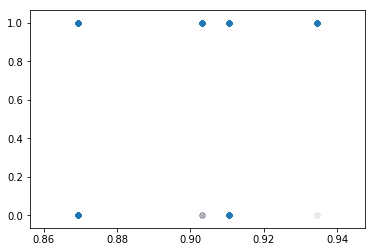

In [17]:
fig, ax = plt.subplots()
ax.scatter(y_pred_b, y_test_b, alpha=0.003)

In [18]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

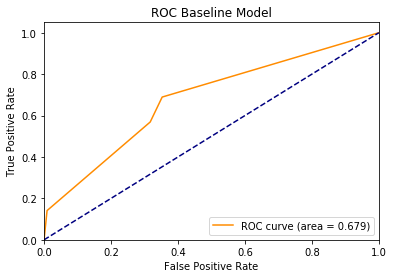

In [19]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - Random Forest

In [20]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_test_t = sample_test['vote']

In [22]:
top_model = RandomForestClassifier(n_estimators=1000, max_depth=11, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [43]:
log_loss(y_test_t, y_pred_t)

0.3530692058687331

In [44]:
y_pred_t.min()

0.2615225983948311

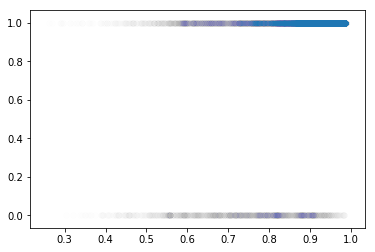

In [45]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.003)

In [46]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [47]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.803178691950253

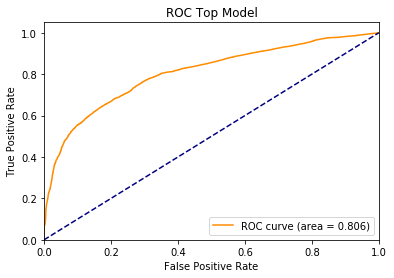

In [521]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

### Trying Gradient Boosting Classifier

In [357]:
# TRAIN
X_train_n = sample_train[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_train_n = sample_train['vote']

# TEST
X_test_n = sample_test[['voter_id', 'voting_agency', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num', 
                     'num_sponsors', 'years_until_vote', 'percent_yea', 'num_sections', 'bill_type_score']]

y_test_n = sample_test['vote']

In [420]:
new_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=25, max_depth=6, random_state=709, 
                                       verbose=1)

In [421]:
new_model.fit(X_train_n, y_train_n)

      Iter       Train Loss   Remaining Time 
         1           0.6288           25.99s
         2           0.6196           23.76s
         3           0.6114           22.31s
         4           0.6045           22.82s
         5           0.5984           21.72s
         6           0.5930           20.29s
         7           0.5881           19.02s
         8           0.5838           17.87s
         9           0.5797           16.86s
        10           0.5758           15.93s
        20           0.5475            5.20s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=25,
              presort='auto', random_state=709, subsample=1.0, verbose=1,
              warm_start=False)

25


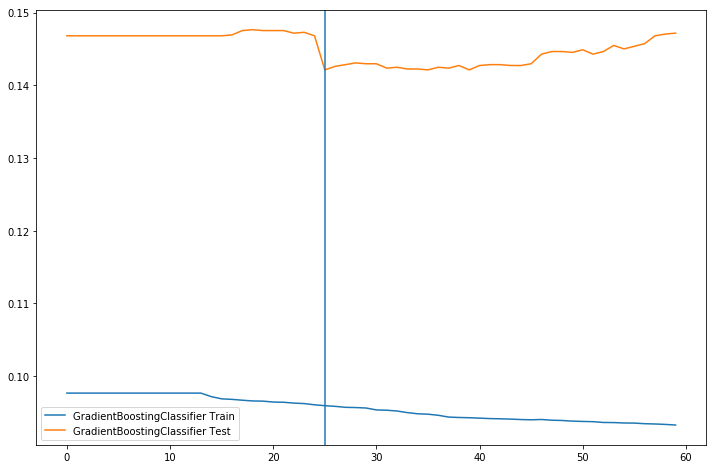

In [419]:
fig, ax = plt.subplots(figsize=(12, 8))
stage_score_plot(new_model, X_train_n, y_train_n, X_test_n, y_test_n, ax)
ax.legend()
plt.show()

In [422]:
y_pred_n = (new_model.predict_proba(X_test_n))[:, 1]

In [423]:
log_loss(y_test_n, y_pred_n)

0.3521900021383175

In [424]:
y_pred_n.min()

0.37285957888024013

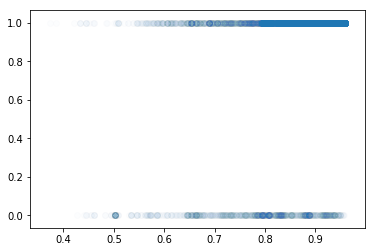

In [425]:
fig, ax = plt.subplots()
ax.scatter(y_pred_n, y_test_n, alpha=0.01)

In [426]:
fpr_n, tpr_n, thresholds_n = roc_curve(y_test_n, y_pred_n)

In [427]:
roc_auc_n = roc_auc_score(y_test_n, y_pred_n)
roc_auc_n

0.7985873138706923

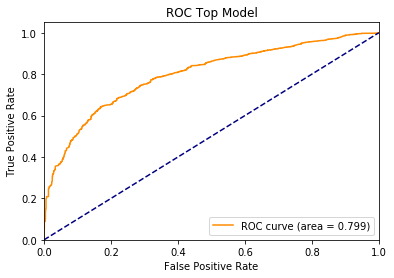

In [428]:
fig, ax = plt.subplots()
plt.plot(fpr_n, tpr_n, color='darkorange', label= f'ROC curve (area = {round(roc_auc_n, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Top Model')
plt.legend(loc="lower right")
plt.show()

### NLP Playground

In [432]:
my_stopwords = ['enacted', 'passed', 'pass', 'yeas', 'nays', 'absents', 'yea', 'nay',
                'absents', 'undecided', 'undecideds']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [429]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [430]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

283316

In [433]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=8000)

In [3]:
fitted = tf.fit(bills)

In [ ]:
transformed_train = tf.transform(bills)

In [ ]:
transformed_test = tf.transform(bills_test)

In [ ]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = X_train.reset_index().drop('index', axis=1)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = X_test.reset_index().drop('index', axis=1)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [ ]:
model = RandomForestClassifier(n_estimators=5000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
X_train.columns

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted

### Topic Playground

In [ ]:
# bills = sample_one_year['bill_text']

In [ ]:
# wordnet = WordNetLemmatizer()

In [ ]:
# def create_bill_tokens(bill):
#     bill = bill.replace('\n', ' ') 
#     punctuations = set(string.punctuation)
    
#     bill = ''.join([char.lower() for char in bill if char not in punctuations])
#     bill_tokens = bill.split(' ')
#     lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
#     return lemmed_bill

In [ ]:
topic_df = pd.read_csv('topic_staging_better.csv', sep="|")

In [ ]:
topic_df['bill_num_unique'] = topic_df['biennium'] + ' ' + topic_df['bill_num'].apply(str)

In [ ]:
topic_df = topic_df.drop('biennium', axis=1)

In [ ]:
MERGED = sample_train.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGED_train = MERGED[MERGED['bill_id_y'].notnull()]

In [ ]:
MERGED_test = sample_test.merge(topic_df, how='left', on='bill_num_unique')

In [ ]:
MERGED_test = MERGED_test[MERGED_test['bill_id_y'].notnull()]

In [ ]:
MERGED_train.columns

In [ ]:
# TRAIN
X_train = MERGD_train.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x', 'bill_id_y', 'htm_url',
                            'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                            'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                             axis=1)

y_train = MERGD_train['vote']

# TEST
X_test = MERGD_test.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id_x','bill_id_y', 'htm_url',
                          'bill_text', 'first_date_read', 'bill_num_unique', 'secondary_sponsors', 
                          'primary_sponsor_id', 'congress_num', 'dem_score', 'vote_year', 'first_year_read'], 
                           axis=1)

y_test = MERGD_test['vote']

In [ ]:
model = RandomForestClassifier(n_estimators=2000, max_depth=6, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [ ]:
log_loss(y_test, y_pred)

In [ ]:
y_pred.min()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

In [ ]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [ ]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns)

In [ ]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [ ]:
features_importances_sorted[0:20]

# Explore bill_text

In [64]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

yeas.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
3097375,1,2018-03-01,1659,0,2017-18 SHB 2998,103639.0,2017-18,SHB 2998,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,"{15817,1543,9207,15816,18265}",18265,0.00,1.00,3180,27,7,2018,2018.0,0.0
881032,1,1998-02-10,1585,0,1997-98 SHB 2672,25621.0,1997-98,SHB 2672,http://app.leg.wa.gov/documents/billdocs/1997-...,0,...,"{2153,2174,1592,406,382,1594}",1594,0.50,0.50,1667,7,7,1998,1998.0,0.0
3151171,1,2018-02-27,13198,0,2017-18 SSB 5996,105726.0,2017-18,SSB 5996,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,"{1407,5155,5156,12003,12002,15821,27290,21520,...",1950,0.00,1.00,2548,27,12,2018,2018.0,0.0
2432392,1,2011-03-03,1659,0,2011-12 HB 1178,79451.0,2011-12,HB 1178,http://app.leg.wa.gov/documents/billdocs/2011-...,0,...,"{3478,10031}",10031,0.25,0.75,13506,21,3,2011,2011.0,0.0
1670454,1,2005-03-11,972,0,2005-06 SHB 1394,54299.0,2005-06,SHB 1394,http://app.leg.wa.gov/documents/billdocs/2005-...,0,...,"{2314,2166,8237,972}",972,0.25,0.75,12451,15,5,2005,2005.0,0.0


In [65]:
nays.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,bill_length,congress_num,num_sponsors,vote_year,first_year_read,years_until_vote
2997634,0,2018-02-27,17217,1,2017-18 EHB 1237,100330.0,2017-18,EHB 1237,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,"{18057,9207,17307,10031,3483,16462,17224,10039...",9997,0.095238,0.904762,12836,27,25,2018,2017.0,1.0
3151895,0,2018-02-27,15809,0,2017-18 ESSB 6002,105739.0,2017-18,ESSB 6002,http://app.leg.wa.gov/documents/billdocs/2017-...,1,...,"{1407,5155,14325,17226,27211,14074,13546,12003...",27290,0.000000,1.000000,32142,27,25,2018,2018.0,0.0
1376648,0,2001-03-13,633,1,2001-02 SSB 5965,43637.0,2001-02,SSB 5965,http://app.leg.wa.gov/documents/billdocs/2001-...,1,...,"{2153,2304,644,347,409}",409,0.000000,1.000000,3761,11,6,2001,2001.0,0.0
2394363,0,2010-03-05,9550,0,2009-10 ESSB 6444,78003.0,2009-10,ESSB 6444,http://app.leg.wa.gov/documents/billdocs/2009-...,1,...,"{8214,337}",337,0.250000,0.750000,744659,19,3,2010,2010.0,0.0
2235843,0,2009-03-09,3478,0,2009-10 ESHB 1939,72569.0,2009-10,ESHB 1939,http://app.leg.wa.gov/documents/billdocs/2009-...,0,...,"{12084,9997,2166,9207,8420,2144,10039,8212,347...",10249,0.214286,0.785714,19888,19,16,2009,2009.0,0.0


In [67]:
print(yeas.loc[3097375, 'bill_text'])

 to providing a business and occupation tax exemption for accountable communities of health; adding a new section to chapter 82.04 rcw; creating new sections; and declaring an emergency.be it enacted by the legislature of the state of washington:new section.  sec. 1.  (1) this section is the tax preference performance statement for the tax preference contained in section 2, chapter . . ., laws of 2018 (section 2 of this act). the performance statement is only intended to be used for subsequent evaluation of the tax preference. it is not intended to create a private right of action by any party or be used to determine eligibility for preferential tax treatment.(2) the legislature categorizes this tax preference as one intended to reduce structural inefficiencies in the tax structure under rcw 82.32.808(2)(d).(3) the legislature acknowledges the importance of accountable communities of health under rcw 41.05.800 in aligning actions to achieve healthy communities and populations, improvin

In [68]:
print(nays.loc[2235843, 'bill_text'])

 to vehicle dealer documentary service fees; and amending rcw 46.70.180.be it enacted by the legislature of the state of washington:sec. 1 rcw 46.70.180 and 2007 c 155 s 2 are each amended to read as follows:     each of the following acts or practices is unlawful:     (1) to cause or permit to be advertised, printed, displayed, published, distributed, broadcasted, televised, or disseminated in any manner whatsoever, any statement or representation with regard to the sale, lease, or financing of a vehicle which is false, deceptive, or misleading, including but not limited to the following:     (a) that no down payment is required in connection with the sale of a vehicle when a down payment is in fact required, or that a vehicle may be purchased for a smaller down payment than is actually required;     (b) that a certain percentage of the sale price of a vehicle may be financed when such financing is not offered in a single document evidencing the entire security transaction;     (c) th